# **TP4 : premiers vers les réseaux de neurones profonds**


# Context & Objectives

In this TP, we propose to reformulate linear and logistic regression models as one-layered neural networks, and implement them in [Tensorflow](https://www.tensorflow.org/?hl=fr). We will also benchmark performance of several models, from a simple linear regression to a fully-connected deep learning model. 



We will be using the AUTO-MPG dataset, downloaded as follows:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import tensorflow as tf

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.12.0


In [4]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

import tensorboard
tensorboard.__version__

# Clear any logs from previous runs
! rm -rf ./logs/

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

TensorFlow version:  2.12.0


In [5]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()

dataset.tail()
dataset.shape

(398, 8)

In [6]:
dataset.describe().T[['mean', 'std']]

,mean,std
MPG,23.514573,7.815984
Cylinders,5.454774,1.701004
Displacement,193.425879,104.269838
Horsepower,104.469388,38.491160
Weight,2970.424623,846.841774
Acceleration,15.568090,2.757689
Model Year,76.010050,3.697627
Origin,1.572864,0.802055


# 1. Dataset preparation

**Question 1.1 (BONUS, the solution is given..)** : using the pandas library, count and remove all NaN values. Also, the variable `Origin` refers to different countries, ie 1, 2 and 3 correspond to the country names 'USA', 'Europe' and 'Japan'. Replace these numerical values by these names. One-hot encode these values with [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).


In [7]:
# here is what a one-hot encoding looks like
pd.get_dummies(dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'}), columns=['Origin'], prefix='', prefix_sep='')

,Europe,Japan,USA
0,False,False,True
1,False,False,True
2,False,False,True
3,False,False,True
4,False,False,True
...,...,...,...
393,False,False,True
394,True,False,False
395,False,False,True
396,False,False,True


In [8]:
# just count the number of nans in the dataset
number_nans = dataset.isna().sum()

# remove all rows containing at least one nan
dataset = dataset.dropna()

# write the names of countries in the variable Origin
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

# one-hot encode the variable Origin
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


**Question 1.2 (BONUS, the solution is given..)** : create the train/test partition with a ratio of 0.8/0.2, using the variable `MPG` as label vector.

*tips : to keep working with pandas objects, you can use the [`sample`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) method*

In [9]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG') # this will define train_labels as the column MPG of train_features while removing this column in train_features
test_labels = test_features.pop('MPG')

**Question 1.3**: create a numpy array `X` by normalizing your training features using [`tf.keras.layers.Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization)

In the following, we will not use this variable as this normalization will directly take the form of a neural network layer.

In [10]:
# normalize the training features
X = train_features.copy()
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(np.array(X['Horsepower'])[:,np.newaxis])

Metal device set to: Apple M1


2023-04-14 11:53:48.106733: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


# 2. Linear regression model (using a neural network)



In this section we will try to predict the variable `MPG` with the single predictive variable `Horsepower`



In [11]:
horsepower = np.array(train_features['Horsepower'])[:,np.newaxis]

**Question 2.1**: build a neural network architecture for a linear regression using the `tf.keras.Sequential` tool. Re-use [`tf.keras.layers.Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization) to integrate your normalization to the architecture. Visualize the model with the `summary()` method and comment output shapes and numbers of parameters.

In [12]:
# build the model
model = tf.keras.Sequential([
    tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(units=1)
])
model.build(input_shape=(None, 1))

# visualize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


**Question 2.2**: [compile](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) the model using a Stochastic Gradient Descent optimizer and a Mean Absolute Error both as loss and accuracy metric. [Fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) it to your data.

In [13]:
# compile the model
model.compile(optimizer='sgd',
              loss='mae',
              metrics=['mae'])

# fit the model
model.fit(horsepower, train_labels, epochs=100, callbacks=[tensorboard_callback])

Epoch 1/100
10/10 [==============================] - 0s 6ms/step - loss: 50.7935 - mae: 50.7935
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 46.9554 - mae: 46.9554
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 54.5061 - mae: 54.5061
Epoch 4/100
10/10 [==============================] - 0s 4ms/step - loss: 54.9874 - mae: 54.9874
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 48.9641 - mae: 48.9641
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 54.9988 - mae: 54.9988
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 54.8151 - mae: 54.8151
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 49.9601 - mae: 49.9601
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 54.4572 - mae: 54.4572
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 54.9875 - mae: 54.9875
Epoch 11/100
10/10 [===================

**Question 2.3**: visualize the evolution of your loss function

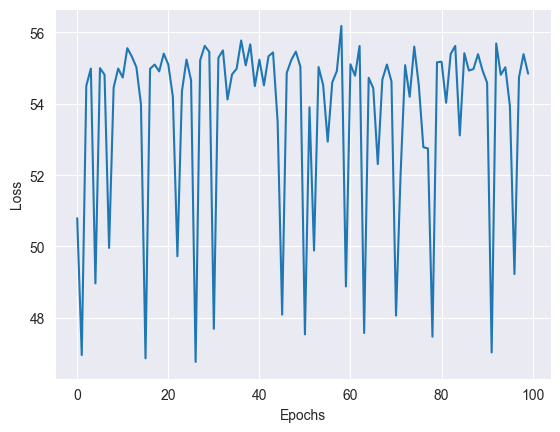

In [14]:
# plot the evolution of the loss function
plt.plot(model.history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

**Question 2.4**: plot the regression line on your data 

*tips : two possible solutions, 1) based on your model predictions with the method using [predict](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict), 2) based on your model coefficients using [get_weights](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#get_weights)*


In [15]:
def normalize(x):
    mean = np.mean(x)
    std = np.std(x)
    return (x - mean) / std

10/10 [==============================] - 0s 2ms/step


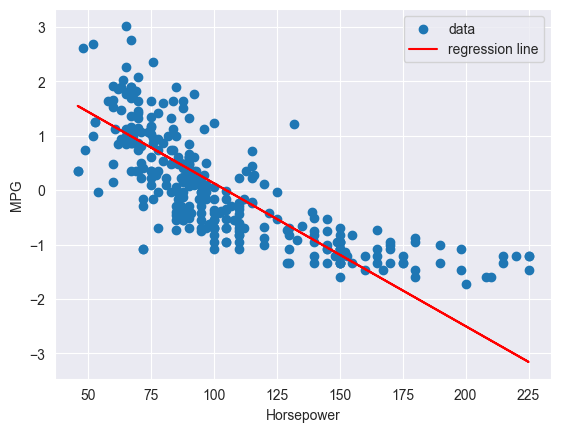

In [16]:
# plot the regression line
plt.scatter(horsepower, normalize(train_labels), label='data')
plt.plot(horsepower, normalize(model.predict(horsepower)), color='red', label='regression line')
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.legend()
plt.show()

**Question 2.5**: [evaluate](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate) your performance model, and store them into a dictionary having model names as keys

In [17]:
# evaluate the model
model.evaluate(horsepower, train_labels, verbose=2)

# store the results
results = {'linear regression': model.evaluate(horsepower, train_labels, verbose=2)}

# print the results
print(results)

10/10 - 0s - loss: 67.9937 - mae: 67.9937 - 95ms/epoch - 9ms/step
10/10 - 0s - loss: 67.9937 - mae: 67.9937 - 42ms/epoch - 4ms/step
{'linear regression': [67.99369049072266, 67.99369049072266]}


# 3. Multilinear regression model (using a neural network)

**Question 3.1**: answer all previous questions for a multilinear regression model taking as inputs all available variables. Comment optimization and performance results.

In [18]:
## multi-linear regression
# take all available variables as input
multilinear_features = train_features.copy()
multilinear_features = np.array(multilinear_features).astype(np.float32)

Epoch 1/100
10/10 [==============================] - 0s 5ms/step - loss: 44494.7266 - mae: 44494.7266
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 44603.8789 - mae: 44603.8789
Epoch 3/100
10/10 [==============================] - 0s 4ms/step - loss: 44446.0469 - mae: 44446.0469
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 44572.3008 - mae: 44572.3008
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 44377.4219 - mae: 44377.4219
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 44310.2227 - mae: 44310.2227
Epoch 7/100
10/10 [==============================] - 0s 4ms/step - loss: 44230.5820 - mae: 44230.5820
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 44778.0898 - mae: 44778.0898
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 44640.3203 - mae: 44640.3203
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 44559.47

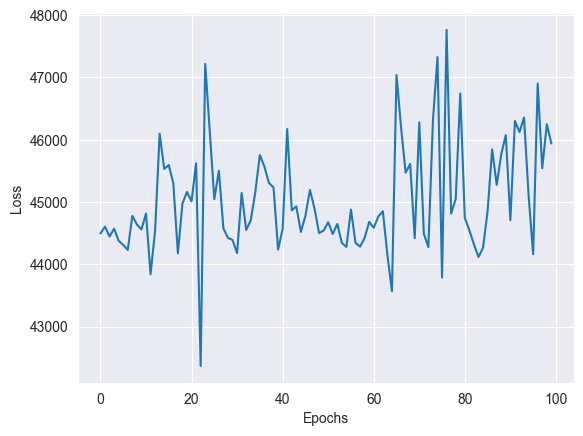

10/10 - 0s - loss: 79401.4922 - mae: 79401.4922 - 78ms/epoch - 8ms/step
{'linear regression': [67.99369049072266, 67.99369049072266], 'multilinear regression': [79401.4921875, 79401.4921875]}


In [19]:
# build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

# compile the model
model.compile(optimizer='sgd',
              loss='mae',
              metrics=['mae'])

# fit the model
model.fit(multilinear_features, train_labels, epochs=100, callbacks=[tensorboard_callback])

# plot the evolution of the loss function
plt.plot(model.history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# evaluate the model
results['multilinear regression'] = model.evaluate(multilinear_features, train_labels, verbose=2)

# print the results
print(results)

In [20]:
# optimization
print('===== Optimization results =====')
print('Linear regression: ', results['linear regression'][1])
print('Multilinear regression: ', results['multilinear regression'][1])
print('===== Performance results =====')
print('Linear regression: ', results['linear regression'][0])
print('Multilinear regression: ', results['multilinear regression'][0])

===== Optimization results =====
Linear regression:  67.99369049072266
Multilinear regression:  79401.4921875
===== Performance results =====
Linear regression:  67.99369049072266
Multilinear regression:  79401.4921875


# 4. Fully-connected multi-layer neural network model

**Question 4.1**: write a function `def build_and_compile_model(input, nber_layer, nber_neurons_per_layer, activation):` able to build a fully-connected multi-layer neural network architecture with `nber_layer` layers, each containing `nber_neurons_per_layer` neurons with an activaton stored in the list `activation`.

In [21]:
def build_and_compile_model(input, nber_layer, nber_neurons_per_layer, activation):
    # build a fully-connected multi-layer neural network architecture
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(nber_neurons_per_layer, activation=activation, input_shape=(input,)))
    for i in range(nber_layer-1):
        model.add(tf.keras.layers.Dense(nber_neurons_per_layer, activation=activation))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='sgd',
                  loss='mae',
                  metrics=['mae'])
    return model

**Question 4.2**: using this fonction, build and compile a DNN model with two layers of 64 and 32 neurons with `relu` activations to predict MPG from all other variables

In [22]:
# build and compile the model (2 layers of 64 and 32 neurons with relu activations)
model = build_and_compile_model(multilinear_features.shape[1], 2, 64, 'relu')

**Question 4.3**: display a result table showing the MAE for the two models

Epoch 1/100
10/10 [==============================] - 0s 8ms/step - loss: 158600.7344 - mae: 158600.7344
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 6.6052 - mae: 6.6052
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 6.5384 - mae: 6.5384
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 6.5872 - mae: 6.5872
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 6.6314 - mae: 6.6314
Epoch 6/100
10/10 [==============================] - 0s 4ms/step - loss: 6.8394 - mae: 6.8394
Epoch 7/100
10/10 [==============================] - 0s 5ms/step - loss: 6.5490 - mae: 6.5490
Epoch 8/100
10/10 [==============================] - 0s 5ms/step - loss: 6.6638 - mae: 6.6638
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 6.6888 - mae: 6.6888
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 6.5107 - mae: 6.5107
Epoch 11/100
10/10 [=============================

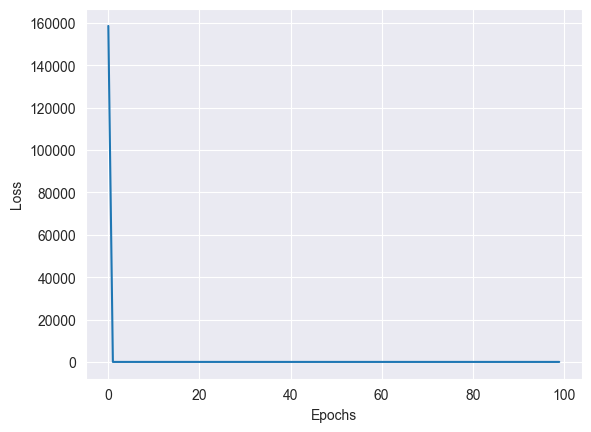

10/10 - 0s - loss: 6.7642 - mae: 6.7642 - 88ms/epoch - 9ms/step
{'linear regression': [67.99369049072266, 67.99369049072266], 'multilinear regression': [79401.4921875, 79401.4921875], 'DNN': [6.76416015625, 6.76416015625]}


In [23]:
# fit the model
model.fit(multilinear_features, train_labels, epochs=100, callbacks=[tensorboard_callback])

# plot the evolution of the loss function
plt.plot(model.history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# evaluate the model
results['DNN'] = model.evaluate(multilinear_features, train_labels, verbose=2)

# print the results
print(results)

# 5. Logistic regression model 

After having performed our model benchmark on a regression task, we will now address a binary classification task using a logistic regression model.

**Question 5.1**: let's start building a dataset suited for this classification task. From the variable `Cylinders`, build a new binary variable with a value of 0 for cylinders values inferior to 5, and 1 otherwise

In [24]:
# build a binary variable from the variable Cylinders
binary_cylinders = np.where(train_features['Cylinders'] < 5, 0, 1)

**Question 5.2**: based on the neural network architecture of a linear regression model (part 2), build a neural network architecture performing a logistic regression model

*tips : think about the neuron activation*

In [25]:
# build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])


**Question 5.3**: compile and fit your model with the proper [loss](https://keras.io/api/losses/), and visualize the evolutions of loss and accuracy metrics

Epoch 1/100
10/10 [==============================] - 0s 8ms/step - loss: 11.9033 - accuracy: 0.5191
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 14.7476 - accuracy: 0.4682
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 11.1343 - accuracy: 0.5127
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 13.3144 - accuracy: 0.4809
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 12.4783 - accuracy: 0.5064
Epoch 6/100
10/10 [==============================] - 0s 5ms/step - loss: 11.2760 - accuracy: 0.5318
Epoch 7/100
10/10 [==============================] - 0s 5ms/step - loss: 14.9623 - accuracy: 0.4618
Epoch 8/100
10/10 [==============================] - 0s 5ms/step - loss: 13.3533 - accuracy: 0.4936
Epoch 9/100
10/10 [==============================] - 0s 5ms/step - loss: 14.0453 - accuracy: 0.4936
Epoch 10/100
10/10 [==============================] - 0s 4ms/step - loss: 16.0913 - accuracy: 0.4108

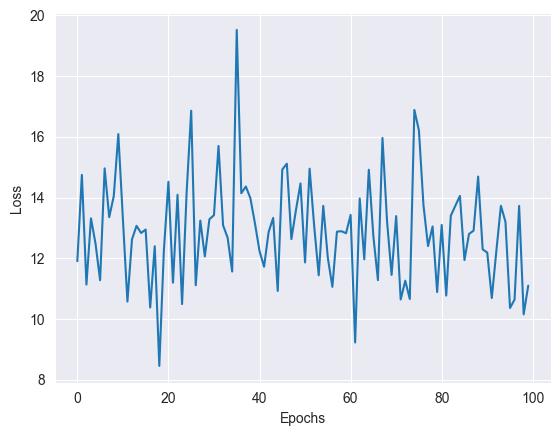

10/10 - 0s - loss: 18.8487 - accuracy: 0.5127 - 110ms/epoch - 11ms/step
{'linear regression': [67.99369049072266, 67.99369049072266], 'multilinear regression': [79401.4921875, 79401.4921875], 'DNN': [6.76416015625, 6.76416015625], 'logistic regression': [18.84871482849121, 0.5127388834953308]}


In [26]:
# compile the model
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# fit the model
model.fit(horsepower, binary_cylinders, epochs=100, callbacks=[tensorboard_callback])

# plot the evolution of the loss function
plt.plot(model.history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# evaluate the model
results['logistic regression'] = model.evaluate(horsepower, binary_cylinders, verbose=2)

# print the results
print(results)

# 6. Visualizing model graphs with tensorboard (optional)

In [27]:
#%load_ext tensorboard

**Question 6:** use [tensorboard](https://www.tensorflow.org/tensorboard/graphs) to examine the graph of your last model

1) on écrit les logs dans le dossier `logs`

In [28]:
#%tensorboard --logdir logs

2) on publie le lien vers le dashboard tensorboard
```bash
$> ! tensorboard dev upload --logdir logs --name "name" --one_shot
```
